<a href="https://colab.research.google.com/github/lukegge/IntroToProgrammingPython/blob/main/deeplearning_introtoprogramming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Group Project

Creators: Luigi, Noemi & BobTheBuilder

The **goal** of this project is to implement and train a neural network to perform image classification. The dataset used is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 32x32 RGB images, showing objects from either of 10 different classes. 

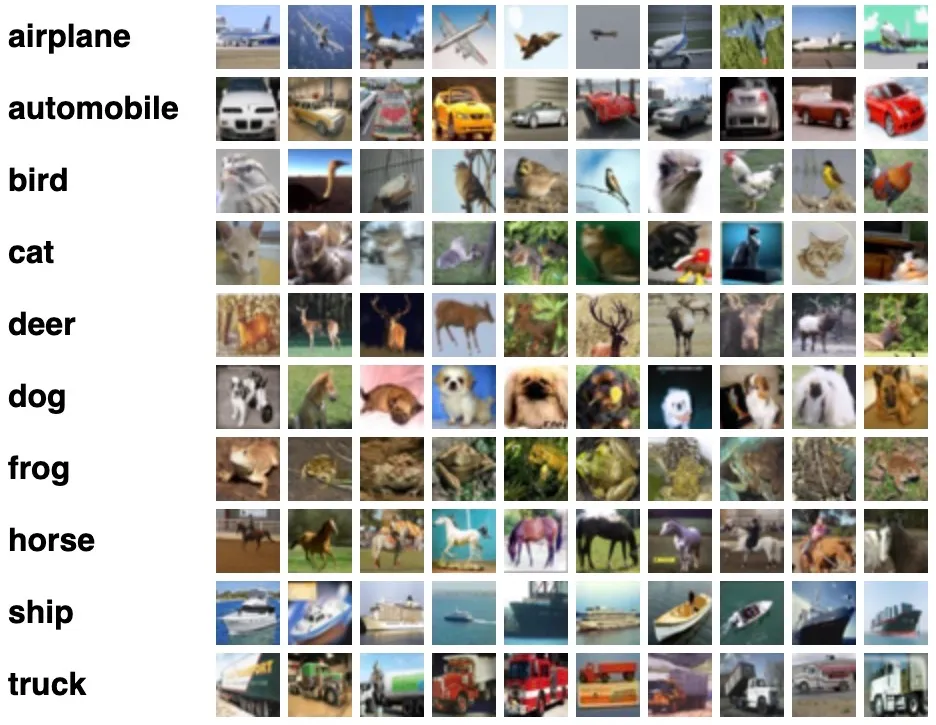

The **steps** are the following:
* Implement a simple neural network architecture.
* For each training epoch, output the loss on the training dataset and the loss on the validation dataset. Tune the learning rate using this setup to maximize the accuracy on the validation dataset and prevent overfitting. Visualize the training and validation loss as a function of epoch for the best-performing learning rate in the same plot.
* Evaluate the final trained and tuned model on the test dataset by computing accuracy, precision and recall, visualize the confusion matrix and discuss implications.
----

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# import the Google Colab GDrive connector
import os
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

# create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
if not os.path.exists(data_directory): os.makedirs(data_directory)

Mounted at /content/drive


----
## Basic CNN Model

1. **Importing Libraries:** The script begins by importing all necessary Python libraries such as NumPy, PyTorch, torchvision, and Scikit-learn. These libraries provide the necessary functionalities for data manipulation, deep learning model development, image processing, and evaluation of results.
2. **Set Seed for Reproducibility:** The script sets a seed for NumPy and PyTorch to ensure the reproducibility of the results.
3. **Checking CUDA Availability:** The script checks if CUDA is available for the script to use. CUDA is a parallel computing platform and application programming interface model created by NVIDIA which allows using GPU for general purpose processing.
4. **Data Preparation:** The CIFAR-10 dataset is downloaded and preprocessed. The preprocessing includes data augmentation for the training set (random horizontal flip and random cropping) and normalization of images in both training and testing sets.
5. **DataLoader Creation:** PyTorch's DataLoader is used to create a batch loader for the training and testing datasets, which provides an easy way to iterate over the datasets in batches.
6. **Model Definition:** A convolutional neural network (CNN) model is defined for the task of image classification. The model consists of two convolutional layers followed by three fully connected layers. The ReLU activation function is used, and MaxPooling is applied after the convolutions.
7. **Model Training:** The script trains the model using the Stochastic Gradient Descent (SGD) optimizer and Cross Entropy Loss as the loss function. The training is done for a predefined number of epochs, and for each epoch, the average training and validation loss is computed and printed.
8. **Model Evaluation:** After training, the script evaluates the model on the test dataset. The evaluation metrics are accuracy, F1-score, precision, and recall, computed using the functions provided by Scikit-learn. The results of the evaluation are then printed.




In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torchvision
from torchvision import transforms

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.manual_seed(seed_value)
print('[LOG] notebook with {} computation enabled'.format(str(device)))

# Download and preprocess the CIFAR-10 dataset
data_directory = './data_cifar10'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Just normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the datasets
trainset = torchvision.datasets.CIFAR10(root=data_directory, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_directory, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Define the model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item()
    return running_loss / len(loader)

# Prediction function
def predict(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move tensors to the device
            y_pred_batch = model(X_batch)
            _, y_pred_batch = torch.max(y_pred_batch, dim=1)
            y_pred.extend(y_pred_batch.tolist())
            y_true.extend(y_batch.tolist())
    return y_true, y_pred

# Evaluation metric function
def print_evaluation_scores(y_true, y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('F1-score:', f1_score(y_true, y_pred, average='weighted'))
    print('Precision:', precision_score(y_true, y_pred, average='weighted'))
    print('Recall:', recall_score(y_true, y_pred, average='weighted'))

# Train and evaluate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    valid_loss = evaluate(model, testloader, criterion)
    print(f"Epoch: {epoch+1}/{num_epochs}.. Training Loss: {train_loss:.3f}.. Validation Loss: {valid_loss:.3f}")

# Evaluate the model
y_test_true, y_test_pred = predict(model, testloader)
print("Model evaluation:")
print_evaluation_scores(y_test_true, y_test_pred)

[LOG] notebook with cuda computation enabled


100%|██████████| 170498071/170498071 [00:03<00:00, 49091190.00it/s]


Extracting ./data_cifar10/cifar-10-python.tar.gz to ./data_cifar10
Files already downloaded and verified
Epoch: 1/10.. Training Loss: 2.303.. Validation Loss: 2.300
Epoch: 2/10.. Training Loss: 2.293.. Validation Loss: 2.280
Epoch: 3/10.. Training Loss: 2.233.. Validation Loss: 2.135
Epoch: 4/10.. Training Loss: 2.069.. Validation Loss: 1.966
Epoch: 5/10.. Training Loss: 1.950.. Validation Loss: 1.846
Epoch: 6/10.. Training Loss: 1.862.. Validation Loss: 1.755
Epoch: 7/10.. Training Loss: 1.784.. Validation Loss: 1.677
Epoch: 8/10.. Training Loss: 1.724.. Validation Loss: 1.641
Epoch: 9/10.. Training Loss: 1.680.. Validation Loss: 1.574
Epoch: 10/10.. Training Loss: 1.649.. Validation Loss: 1.551
Model evaluation:
Accuracy: 0.4324
F1-score: 0.4193461237914542
Precision: 0.4314436942205491
Recall: 0.4324


**Discussion:** The model was trained for 10 epochs, and the training loss steadily decreased from 2.303 to 1.649, indicating that the model was learning and improving its performance on the training data. The validation loss also decreased from 2.300 to 1.551, which suggests that the model was not overfitting the training data and was able to generalize to unseen data.

After training, the model achieved an accuracy of 43.24% on the test data. The F1-score was 0.419, precision was 0.431, and recall was 0.432. All these values are low, which indicates that the model's performance is relatively poor.

----
## Different Improvements
### Data augmentation
Data augmentation is a technique in machine learning used to reduce overfitting when training a machine learning model, by training models on several slightly-modified copies of existing data. (Wikipedia)

1. **Set Seed for Reproducibility:** The seed for NumPy and PyTorch is set again to ensure that the results can be reproduced.
2. **Data Preparation:** Two sets of transformations are prepared for the images - one for the training set and another for the validation and testing sets. For the training set, the images are randomly flipped horizontally and randomly cropped, in addition to being converted to tensors and normalized. For the validation and testing sets, the images are just converted to tensors and normalized.
3. **Data Loading:** The CIFAR-10 dataset is loaded again, this time separately for training and evaluation. The data loaders are also prepared, which allow for easy iteration over the datasets in batches. Note that the training data is shuffled for each epoch, which helps prevent the model from learning the order of the training data and thus improves generalization.
4. **Creating Validation and Test Sets:** The evaluation dataset is divided into two equal subsets, one for validation during training and one for testing the model after training. This is done using the train_test_split function from Scikit-learn, which stratifies the data (i.e., it ensures that the class proportions are maintained in the subsets). The Subset utility from PyTorch is used to create these subsets.
5. **Model Training:** Similar to the previous snippet, the model is trained for a predefined number of epochs, and the training and validation losses are printed for each epoch. This time, however, the validation is done on the newly created validation set.
6. **Model Evaluation:** Finally, the model is evaluated on the test set, with the evaluation metrics (accuracy, F1-score, precision, and recall) being computed and printed. Again, this is done on the newly created test set.

In [3]:
import torchvision.transforms as transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)

data_directory = './data_cifar10'

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_path = data_directory + '/train_cifar10'
cifar10_train = torchvision.datasets.CIFAR10(root=train_path, train=True, download=True, transform=train_transform)
train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=True)

eval_path = data_directory + '/eval_cifar10'
cifar10_eval = torchvision.datasets.CIFAR10(root=eval_path, train=False, download=True, transform=val_test_transform)

indices = list(range(len(cifar10_eval)))
val_indices, test_indices = train_test_split(indices, test_size=0.5, stratify=cifar10_eval.targets, random_state=seed_value)

val_dataset = Subset(cifar10_eval, val_indices)
test_dataset = Subset(cifar10_eval, test_indices)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

# Train and evaluate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    valid_loss = evaluate(model, val_loader, criterion)
    print(f"Epoch: {epoch+1}/{num_epochs}.. Training Loss: {train_loss:.3f}.. Validation Loss: {valid_loss:.3f}")

# Evaluate the model
y_test_true, y_test_pred = predict(model, test_loader)
print("Model evaluation:")
print_evaluation_scores(y_test_true, y_test_pred)

100%|██████████| 170498071/170498071 [00:03<00:00, 48334690.84it/s]


Extracting ./data_cifar10/train_cifar10/cifar-10-python.tar.gz to ./data_cifar10/train_cifar10


100%|██████████| 170498071/170498071 [00:03<00:00, 47720967.24it/s]


Extracting ./data_cifar10/eval_cifar10/cifar-10-python.tar.gz to ./data_cifar10/eval_cifar10
Epoch: 1/10.. Training Loss: 1.623.. Validation Loss: 1.526
Epoch: 2/10.. Training Loss: 1.594.. Validation Loss: 1.502
Epoch: 3/10.. Training Loss: 1.575.. Validation Loss: 1.478
Epoch: 4/10.. Training Loss: 1.552.. Validation Loss: 1.450
Epoch: 5/10.. Training Loss: 1.536.. Validation Loss: 1.448
Epoch: 6/10.. Training Loss: 1.516.. Validation Loss: 1.416
Epoch: 7/10.. Training Loss: 1.501.. Validation Loss: 1.394
Epoch: 8/10.. Training Loss: 1.482.. Validation Loss: 1.377
Epoch: 9/10.. Training Loss: 1.471.. Validation Loss: 1.369
Epoch: 10/10.. Training Loss: 1.458.. Validation Loss: 1.366
Model evaluation:
Accuracy: 0.5012
F1-score: 0.48690672421183634
Precision: 0.50189256246711
Recall: 0.5012


----
## Different Architecture (ResNet-18)
This snippet of code extends the image classification task to use a pre-trained ResNet-18 model from PyTorch's torchvision models.

1. **Training Function:** The training function is modified to utilize mixed precision training. This is achieved with PyTorch's Automatic Mixed Precision (AMP) that uses a mix of float16 and float32 data types to make model training faster and more memory-efficient.

2. **Model Setup:** The code trains the ResNet-18 model with different learning rates. For each learning rate, it initializes a pre-trained ResNet-18 model, replaces the last fully connected layer to match the number of classes in the CIFAR-10 dataset (10 classes), and moves the model to the designated device (GPU or CPU).

3. **Optimizer and Loss Function:** The optimizer used is Adam, and the learning rate varies as per the outer loop. The loss function is Cross Entropy Loss, commonly used for multi-class classification problems.

4. **Training and Validation:** The model is trained for a specified number of epochs. For each epoch, it calculates the training and validation loss and appends them to respective lists. It also updates a progress bar to provide a visual representation of the training progress.

5. **Prediction and Accuracy Calculation:** After training for each learning rate, the model's performance is evaluated on the test set, and the accuracy of the model is calculated using the Scikit-Learn's accuracy_score function.

6. **Plotting Validation Loss:** After training and evaluating the model for all learning rates, it plots the validation loss for each learning rate across the epochs. This helps in visualizing how the model's performance varies with the learning rate over time.

7. **Top Configurations:** Finally, it prints the top 5 configurations (learning rate and number of epochs) based on the accuracy of the model on the test set.

In summary, this code trains and evaluates a pre-trained ResNet-18 model on the CIFAR-10 dataset using different learning rates, and then it identifies the top configurations based on the accuracy of the model.

  0%|                                                 | 0/100 [00:00<?, ?step/s]

Training with learning rate: 0.0001


 20%|████████                                | 20/100 [10:36<44:21, 33.27s/step]

Training with learning rate: 0.0005


 40%|████████████████                        | 40/100 [21:06<31:19, 31.33s/step]

Training with learning rate: 0.001


 60%|████████████████████████                | 60/100 [31:24<20:41, 31.03s/step]

Training with learning rate: 0.005


 80%|████████████████████████████████        | 80/100 [41:52<10:27, 31.36s/step]

Training with learning rate: 0.01


100%|███████████████████████████████████████| 100/100 [52:25<00:00, 31.46s/step]


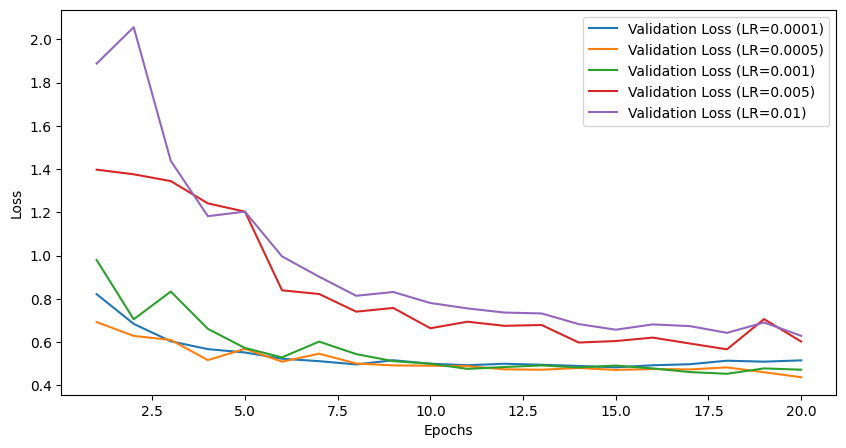

In [5]:
from tqdm import tqdm
from heapq import nlargest
from matplotlib import pyplot as plt
import torch
from torch.cuda.amp import autocast, GradScaler
from torchvision.models.resnet import resnet18, ResNet18_Weights

# Training function
def train(model, loader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        with autocast():
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item()
    return running_loss / len(loader)

def predict(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_true.extend(y_batch.numpy().tolist())
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy().tolist())
    return y_true, y_pred

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
num_epochs = 20

plt.figure(figsize=(10, 5))

config_accuracies = []
num_classes = 10

total_steps = len(learning_rates) * num_epochs
with tqdm(total=total_steps, unit='step', ncols=80, position=0, leave=True) as progress_bar:
    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        model_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, num_classes)
        model_resnet18.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_resnet18.parameters(), lr=lr)
        scaler = GradScaler()

        train_losses = []
        valid_losses = []

        for epoch in range(num_epochs):
            train_loss = train(model_resnet18, train_loader, criterion, optimizer, scaler)
            valid_loss = evaluate(model_resnet18, val_loader, criterion)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            progress_bar.update(1)

        y_test_true, y_test_pred = predict(model_resnet18, test_loader)
        accuracy = accuracy_score(y_test_true, y_test_pred)
        config_accuracies.append((accuracy, lr, num_epochs))
        plt.plot(range(1, num_epochs + 1), valid_losses, label=f'Validation Loss (LR={lr})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Print the top 5 configurations
top_5_configs = nlargest(5, config_accuracies, key=lambda x: x[0])
print("Top 5 configurations:")
for i, config in enumerate(top_5_configs, start=1):
    accuracy, lr, epochs = config
    print(f"{i}. Learning Rate: {lr}, Num Epochs: {epochs}, Accuracy: {accuracy:.4f}")

Top 5 configurations:
1. Learning Rate: 0.0005, Num Epochs: 20, Accuracy: 0.8554
2. Learning Rate: 0.0001, Num Epochs: 20, Accuracy: 0.8502
3. Learning Rate: 0.001, Num Epochs: 20, Accuracy: 0.8460
4. Learning Rate: 0.01, Num Epochs: 20, Accuracy: 0.7908
5. Learning Rate: 0.005, Num Epochs: 20, Accuracy: 0.7890


Now we figured out the best learning rates (some are pretty close, so no 100% certainty). Since epoch 20 shows the best accuracy, we can assume that for now with more epochs the accuracy will continue to improve. Thus, as a next step we can use LR 0.0005 to train the model for 50 epochs and look for the best amount of epochs.

Ep 50/50: TrL: 0.1203, TrA: 0.9576, VL: 0.5556, VA: 0.8612: 100%|█| 50/50 [26:01


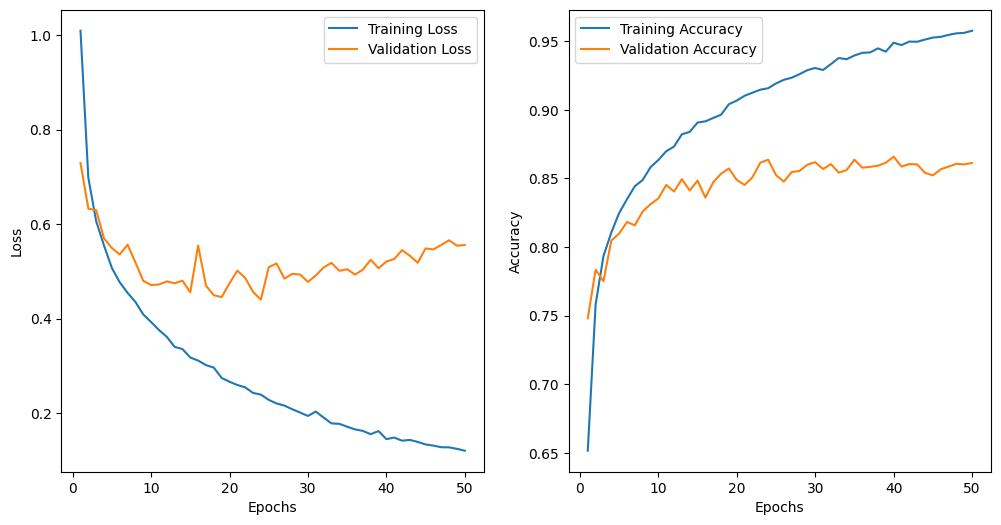

Best validation accuracy at epoch 40 with accuracy 0.8658


In [8]:
# Training function with accuracy calculation
def train_with_accuracy(model, loader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        with autocast():
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    return running_loss / len(loader), correct / total

# Evaluation function with accuracy calculation
def evaluate_with_accuracy(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    return running_loss / len(loader), correct / total

lr = 0.0005
num_epochs = 50

model_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, num_classes)
model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=lr)
scaler = GradScaler()

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Progress bars
epochs_pbar = tqdm(range(num_epochs), ncols=80, position=0, leave=True)

for epoch in epochs_pbar:
    train_loss, train_accuracy = train_with_accuracy(model_resnet18, train_loader, criterion, optimizer, scaler)
    valid_loss, valid_accuracy = evaluate_with_accuracy(model_resnet18, val_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    epochs_pbar.set_description(f"Ep {epoch+1}/{num_epochs}: TrL: {train_loss:.4f}, TrA: {train_accuracy:.4f}, VL: {valid_loss:.4f}, VA: {valid_accuracy:.4f}")

# Plot the losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Find the number of epochs with the best validation accuracy
best_epoch = valid_accuracies.index(max(valid_accuracies)) + 1
print(f"Best validation accuracy at epoch {best_epoch} with accuracy {max(valid_accuracies):.4f}")

Looks like the best number of epochs was around 40. However the accuracy stays roughly the same after 25 epochs. After that point the validation loss increases aswell. (Important to prevent overfitting!). Thus, we can retrain the model for a last time with 25 epochs. We save the model and can then evaluate our findings.

Ep 25/25: TrL: 0.2271, TrA: 0.9195, VL: 0.4551, VA: 0.8552: 100%|█| 25/25 [13:18


Accuracy: 0.8556
Precision: 0.8565
Recall: 0.8556


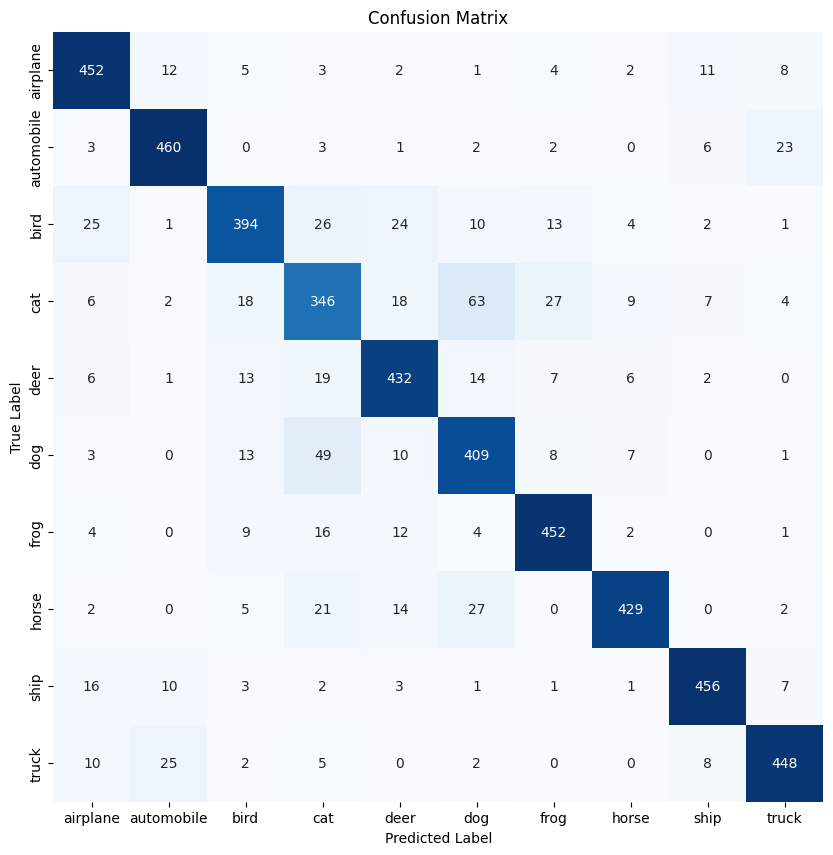

              precision    recall  f1-score   support

    airplane       0.86      0.90      0.88       500
  automobile       0.90      0.92      0.91       500
        bird       0.85      0.79      0.82       500
         cat       0.71      0.69      0.70       500
        deer       0.84      0.86      0.85       500
         dog       0.77      0.82      0.79       500
        frog       0.88      0.90      0.89       500
       horse       0.93      0.86      0.89       500
        ship       0.93      0.91      0.92       500
       truck       0.91      0.90      0.90       500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set the optimal number of epochs and learning rate
num_epochs = 25
best_learning_rate = 0.0005

# Initialize the model
model_resnet18_optimal = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet18_optimal.fc = nn.Linear(model_resnet18_optimal.fc.in_features, num_classes)
model_resnet18_optimal.to(device)

# Set the loss function, optimizer, and scaler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_optimal.parameters(), lr=best_learning_rate)
scaler = GradScaler()

# Initialize progress bar
epochs_pbar = tqdm(range(num_epochs), unit='epoch', ncols=80, position=0, leave=True)

# Retrain the model for 25 epochs
for epoch in epochs_pbar:
    train_loss, train_accuracy = train_with_accuracy(model_resnet18_optimal, train_loader, criterion, optimizer, scaler)
    valid_loss, valid_accuracy = evaluate_with_accuracy(model_resnet18_optimal, val_loader, criterion)
    epochs_pbar.set_description(f"Ep {epoch+1}/{num_epochs}: TrL: {train_loss:.4f}, TrA: {train_accuracy:.4f}, VL: {valid_loss:.4f}, VA: {valid_accuracy:.4f}")

# Save the trained model
torch.save(model_resnet18_optimal.state_dict(), "model_resnet18_optimal.pth")

# Load the saved model
model_resnet18_optimal = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet18_optimal.fc = nn.Linear(model_resnet18_optimal.fc.in_features, num_classes)
model_resnet18_optimal.load_state_dict(torch.load("model_resnet18_optimal.pth"))
model_resnet18_optimal.to(device)

# Get the predictions and true labels
y_test_true, y_test_pred = predict(model_resnet18_optimal, test_loader)

# Calculate the accuracy, precision, and recall
accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='weighted')
recall = recall_score(y_test_true, y_test_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False, xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_true, y_test_pred, target_names=trainset.classes))

**Discussion:** We can see that we achieved quite a solid performance with an **accuracy of 85%**. There are some confusions that stand out tho. Mainly cat/dog and truck/automobile. We could further improve the prediction accuracy by eg training the model with additional images for those classes.

**End of project.**